# 取得股價資料

In [1]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
import matplotlib.pyplot as plt # 繪圖套件

In [4]:
# 取得股票資訊，輸入股票代號
stock_id = "6223.two"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''抓取特定時間'''
start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2023, 1, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位設為資料表索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,79.800003,79.800003,78.400002,78.599998,66.958794,1173000
2020-01-03,79.300003,79.300003,75.199997,75.300003,64.147552,3127898
2020-01-06,75.000000,75.000000,72.800003,73.099998,62.273376,1932000
2020-01-07,73.400002,74.000000,70.099998,71.500000,60.910351,2273000
2020-01-08,70.800003,75.500000,70.500000,74.099998,63.125278,5642000
...,...,...,...,...,...,...
2022-12-26,112.500000,115.500000,111.500000,114.000000,108.071999,1625000
2022-12-27,114.000000,119.500000,114.000000,119.000000,112.812004,3280000
2022-12-28,119.000000,120.500000,115.000000,115.000000,109.019997,2991000


# <b>1. 量化交易策略</b>

## 1.1 均值回歸策略

**如何產生買入和賣出信號？**

* 黃金交叉（Golden Cross）：當短期移動平均線（短期 MA）從下方突破長期移動平均線（長期 MA），這被認為是一個買入信號。這代表著短期內價格上升的趨勢開始超過長期趨勢，市場可能進入一個上漲階段。

* 死亡交叉（Death Cross）：當短期 MA從上方跌破長期 MA，這被認為是一個賣出信號。這代表著短期內的價格趨勢弱於長期趨勢，市場可能進入下跌階段。

In [5]:
# 設計均值回歸策略
def mean_reversion_strategy(data, short_window, long_window):
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

    # 初始訊號：0 代表不操作
    data['Signal'] = 0

    # 短均線高於長均線，發出買入信號
    # .astype('int64') 將 True 變成1，False 變成0
    data.iloc[short_window:, data.columns.get_loc('Signal')] = (
        data['Short_MA'].iloc[short_window:] > data['Long_MA'].iloc[short_window:]
    ).astype('int64')
    # .diff() 使用差分計算買入或賣出(True 代表 1， False代表 0)
    # 當信號從 False（0）變為 True（1）時，1 - 0 = 1 差分為 1，表示買入信號。
    # 當信號從 True（1）變為 False（0）時，0 - 1 = -1 差分為 -1，表示賣出信號。
    data['Position'] = data['Signal'].diff()
    return data

In [6]:
# 回測策略並可視化結果
def backtest_and_plot(data):
    # 資產淨值初始化
    initial_capital = 100000

    # 填空值為 0.0
    positions = pd.DataFrame(index=data.index).fillna(0.0)

    # 買入訊號(1)或賣出訊號(-1) * 股數，-100代表賣100股，100代表買100股
    positions['Stock'] = data['Signal'] * 100  # 每次交易100股

    # 買入或賣出股票數 * 收盤價，計算每個時間點持有的股票價值
    portfolio = positions.multiply(data['Close'], axis=0)

    # 計算每個時間點股票持倉的變化量（買入或賣出股票的數量）
    pos_diff = positions.diff()


    # 計算持有的股票價值（資產組合中持有的部分）
    # 將持倉數量與收盤價相乘，並對每個時間點的所有持倉進行求和，得到當天的總持倉價值
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)

    # 計算現金部分
    # 初始資金減去所有交易的累積花費/收益，並根據股票價格乘以持倉變動來計算現金變化
    # cumsum() 用來累積計算現金變化，保持隨著時間推移的總現金變化
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()

    # 計算總資產
    # 總資產 = 現金部分 + 持有的股票價值部分
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')
    plt.plot(data['Short_MA'], label='Short Moving Average', color='green')
    plt.plot(data['Long_MA'], label='Long Moving Average', color='red')

    # 標註買賣點
    plt.plot(data[data['Position'] == 1].index,
             data['Short_MA'][data['Position'] == 1],
             '^', markersize=10, color='r', lw=0, label='Buy Signal')

    plt.plot(data[data['Position'] == -1].index,
             data['Short_MA'][data['Position'] == -1],
             'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('Mean Reversion Strategy Backtest')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

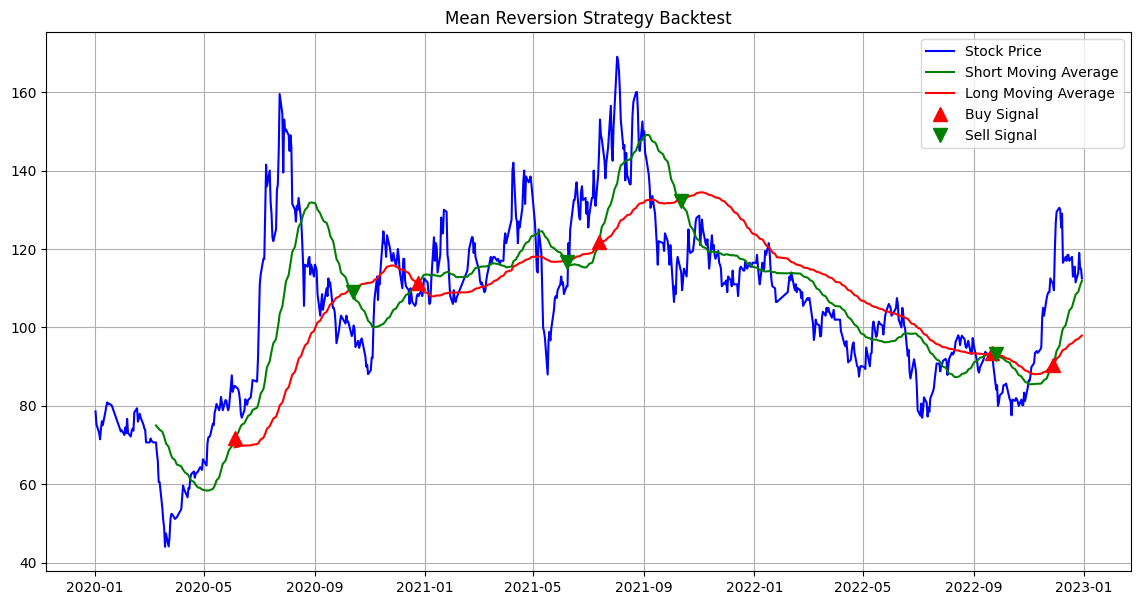

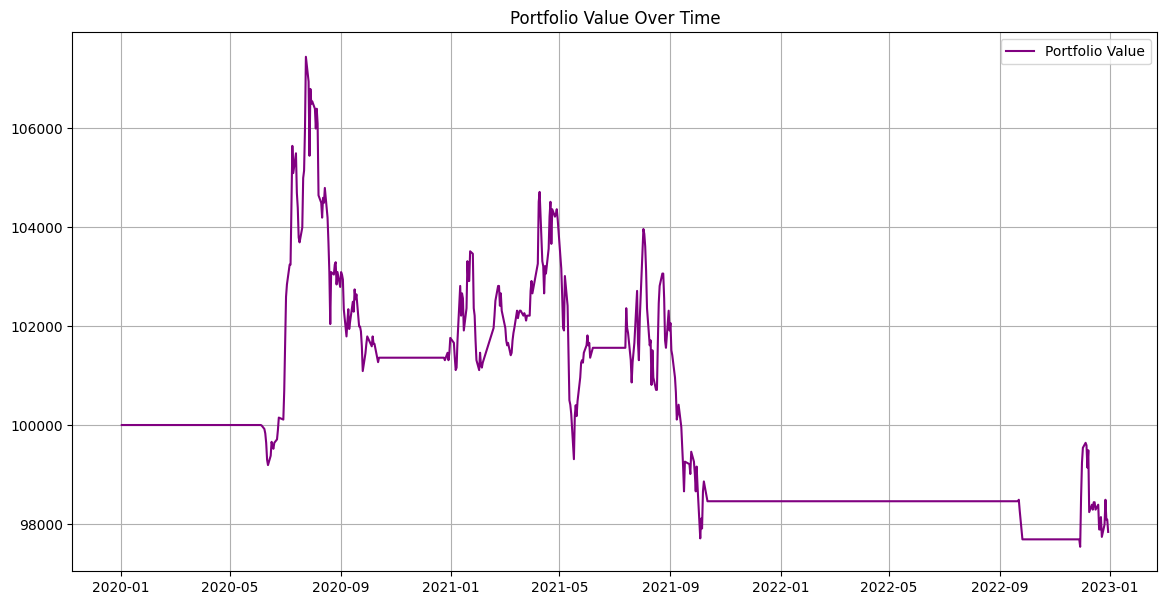

In [7]:
 # 設定策略參數：短期移動平均線窗口與長期移動平均線窗口
short_window = 40
long_window = 100

# 應用均值回歸策略
stock_data = mean_reversion_strategy(stock_data, short_window, long_window)

# 回測並可視化結果
backtest_and_plot(stock_data)

## 2.1 動量策略
**動量策略的基本概念**

1. 趨勢延續：動量策略假設「趨勢具有延續性」。這意味著當某種資產的價格在過去一段時間內持續上升或下降，這個趨勢很有可能在短期內繼續維持。因此，動量策略會根據資產的歷史表現來預測未來的價格變動方向。

2. 上升買入，下降賣出：動量策略的操作原則是「追漲殺跌」：
    * 買入信號：當價格顯示出持續上升的動能時，投資者會進場買入，以期未來價格能夠進一步上漲。
    * 賣出信號：當價格顯示出下降的動能時，投資者會賣出持有的資產，預防價格繼續下跌。

In [8]:
# 輸入股票代號
stock_id = "6223.two"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''抓取特定時間'''
start = dt.datetime(2023, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 1, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位設為資料表索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,113.0,118.5,112.5,118.0,111.863998,2409000
2023-01-04,117.0,118.5,116.0,118.0,111.863998,1608000
2023-01-05,118.0,120.0,116.0,117.5,111.389999,2217000
2023-01-06,117.0,119.0,116.5,118.5,112.337997,1013000
2023-01-09,120.0,121.0,117.0,117.5,111.389999,1753000
...,...,...,...,...,...,...
2023-12-25,214.5,214.5,207.0,207.0,204.412506,1965000
2023-12-26,208.0,210.0,205.5,209.5,206.881256,986000
2023-12-27,209.5,212.0,209.5,211.0,208.362503,764000


In [9]:
# 動量策略設計 (基於價格變動百分比)
def momentum_strategy(data, window, threshold):
    # 計算動量：基於過去 window 天的百分比變化
    # pct_change 計算股票收盤價在指定的時間窗口（window）內的百分比變化
    data['Momentum'] = data['Close'].pct_change(window) * 100  # 轉換為百分比
    data['Signal'] = 0  # 初始訊號

    # 設定當動量變化超過閾值時觸發交易信號
    data.iloc[window:, data.columns.get_loc('Signal')] = [
        1 if momentum > threshold else -1 if momentum < -threshold else 0 for momentum in data['Momentum'].iloc[window:]
    ]

    # 當信號從 0 變為 1 時，1 - 0 = 1 差分為 1，表示買入信號。
    # 當信號從 1 變為 0 時，0 - 1 = -1 差分為 -1，表示賣出信號。
    data['Position'] = data['Signal'].diff()  # 訊號變化產生操作
    return data

In [10]:
# 回測策略並可視化結果
def backtest_and_plot(data):
    # 資產淨值初始化
    initial_capital = 100000

    # 填空值為 0.0
    positions = pd.DataFrame(index=data.index).fillna(0.0)

    # 買入訊號(1)或賣出訊號(-1) * 股數，-100代表賣100股，100代表買100股
    positions['Stock'] = data['Signal'] * 100  # 每次交易100股

    # 買入或賣出股票數 * 收盤價，計算每個時間點持有的股票價值
    portfolio = positions.multiply(data['Close'], axis=0)

    # 計算每個時間點股票持倉的變化量（買入或賣出股票的數量）
    pos_diff = positions.diff()


    # 計算持有的股票價值（資產組合中持有的部分）
    # 將持倉數量與收盤價相乘，並對每個時間點的所有持倉進行求和，得到當天的總持倉價值
    portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)

    # 計算現金部分
    # 初始資金減去所有交易的累積花費/收益，並根據股票價格乘以持倉變動來計算現金變化
    # cumsum() 用來累積計算現金變化，保持隨著時間推移的總現金變化
    portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()

    # 計算總資產
    # 總資產 = 現金部分 + 持有的股票價值部分
    portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

    # 繪製策略結果
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Stock Price', color='blue')

    # 標註買賣信號
    plt.plot(data[data['Position'] == 1].index,
             data['Close'][data['Position'] == 1],
             '^', markersize=10, color='r', lw=0, label='Buy Signal')

    plt.plot(data[data['Position'] == -1].index,
             data['Close'][data['Position'] == -1],
             'v', markersize=10, color='g', lw=0, label='Sell Signal')

    plt.title('Momentum Strategy with Percentage Change and Threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # 繪製資產淨值曲線
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

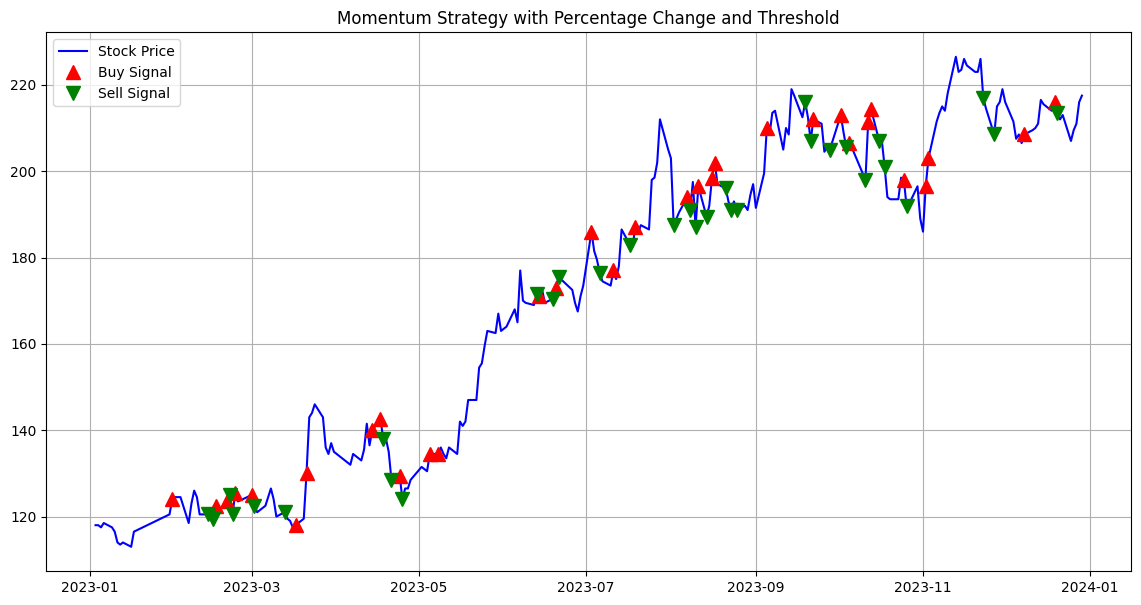

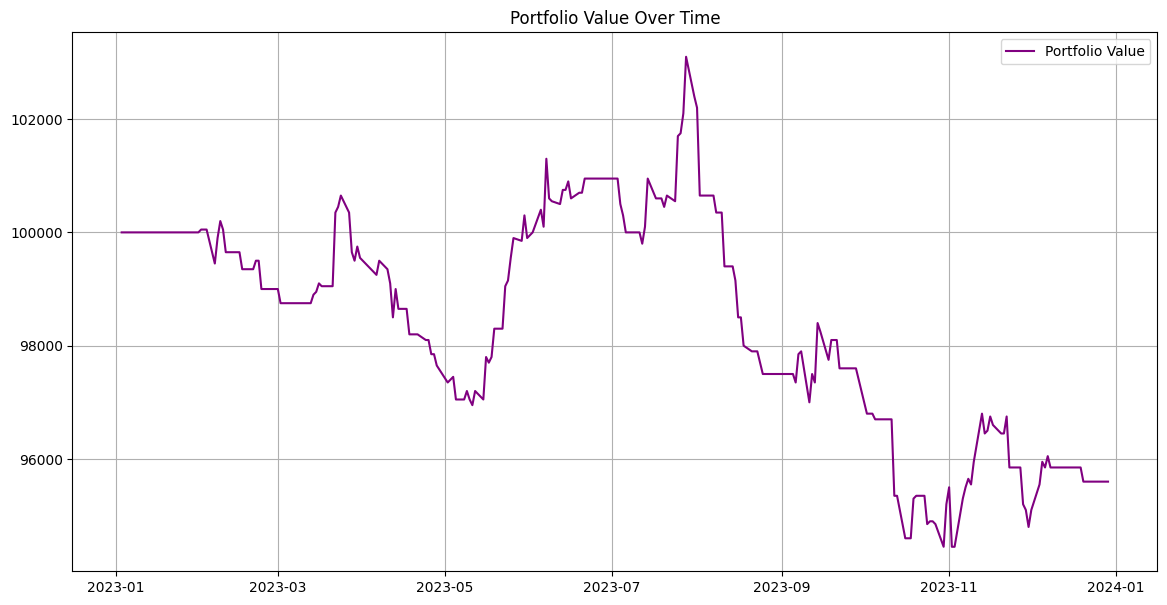

In [11]:
# 設定策略參數：動量計算的窗口期與百分比閾值
momentum_window = 10  # 設定動量窗口為10天
threshold = 3  # 當價格變動百分比超過3%時觸發買賣信號

# 應用動量策略
stock_data = momentum_strategy(stock_data, momentum_window, threshold)

# 回測並可視化結果
backtest_and_plot(stock_data)

# <b>2. 深度學習預測股價</b>

In [12]:
import yfinance as yf  # Yahoo Finance 資料擷取套件
import datetime as dt  # 日期與時間處理套件
import pandas as pd  # 資料處理套件
import numpy as np  # 數值計算套件
import matplotlib.pyplot as plt  # 繪圖套件
from tensorflow.keras.models import Sequential  # Keras 神經網路模型構建工具
from tensorflow.keras.layers import Dense  # Keras 全連接層 (Dense layer)
from sklearn.preprocessing import MinMaxScaler  # 特徵縮放器 (Min-Max 標準化)
from sklearn.metrics import mean_squared_error  # 衡量模型誤差 (均方誤差)

In [13]:
# Step 1: 設置股票代號和時間段
stock_id = "6223.TWo"
start = dt.datetime(2020, 1, 1)  # 開始日期
end = dt.datetime(2023, 1, 1)    # 結束日期

# Step 2: 下載股票數據
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 設置日期索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,79.800003,79.800003,78.400002,78.599998,66.958794,1173000
2020-01-03,79.300003,79.300003,75.199997,75.300003,64.147552,3127898
2020-01-06,75.000000,75.000000,72.800003,73.099998,62.273376,1932000
2020-01-07,73.400002,74.000000,70.099998,71.500000,60.910351,2273000
2020-01-08,70.800003,75.500000,70.500000,74.099998,63.125278,5642000
...,...,...,...,...,...,...
2022-12-26,112.500000,115.500000,111.500000,114.000000,108.071999,1625000
2022-12-27,114.000000,119.500000,114.000000,119.000000,112.812004,3280000
2022-12-28,119.000000,120.500000,115.000000,115.000000,109.019997,2991000


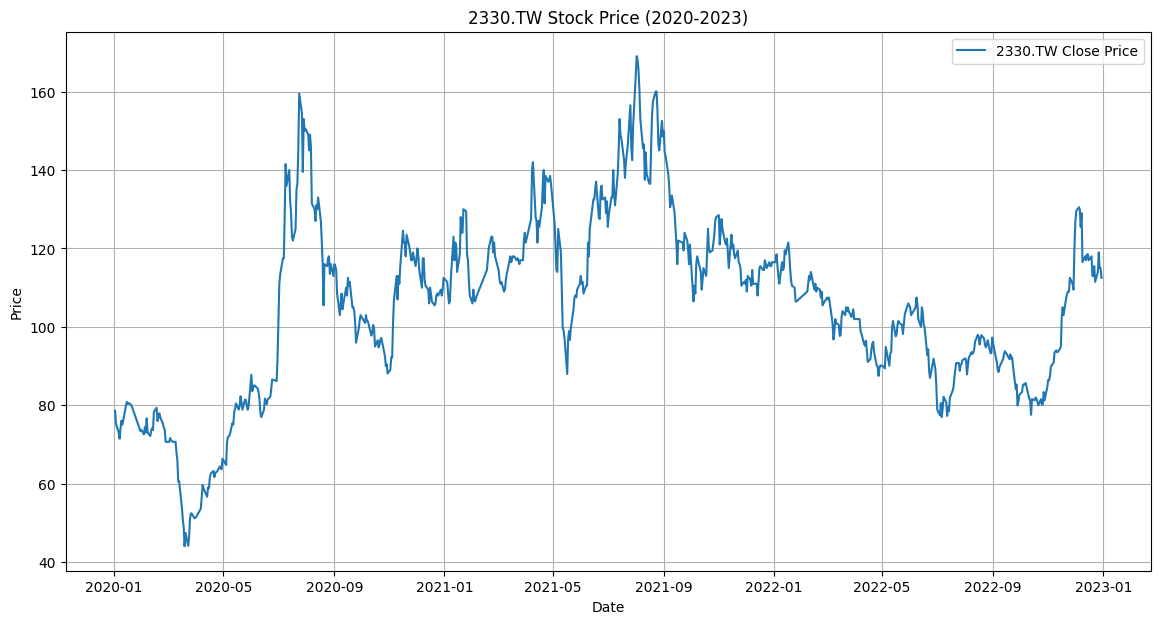

In [14]:
# Step 3: 可視化股票收盤價
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'], label="2330.TW Close Price")
plt.title("2330.TW Stock Price (2020-2023)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Step 4: 構建訓練和測試數據
train_size = int(len(stock_data) * 0.8)
train_data, test_data = stock_data[['Close']][:train_size], stock_data[['Close']][train_size:]

In [16]:
# Step 5:
# 創建 MinMaxScaler 實例，設定範圍為 (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# 使用訓練數據來擬合標準化模型，並對訓練和測試數據進行轉換
train_data_scaled = scaler.fit_transform(train_data)  # 擬合並轉換訓練數據
test_data_scaled = scaler.transform(test_data)        # 僅轉換測試數據

In [17]:
# Step 6: 建立 ANN 模型
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))  # 第一隱藏層
model.add(Dense(32, activation='relu'))               # 第二隱藏層
model.add(Dense(1, activation='linear'))              # 輸出層
model.compile(loss='mse', optimizer='adam')

c:\Users\user\.conda\envs\ForTorch\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Step 7: 訓練模型
X_train, y_train = train_data_scaled[:-1], train_data_scaled[1:] # 使用今天的股價預測明天的股價
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3742   
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.1574
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.0676
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.0166
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0047
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.0026
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0017
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0012   
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0011   
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0011
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.0010   
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0012
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.0010
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0010   
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70

In [19]:
# Step 8: 預測測試數據
X_test, y_test = test_data_scaled[:-1], test_data_scaled[1:]
predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [20]:
# Step 9: 反轉標準化
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [21]:
# Step 10: 使用 RMSE 評估模型
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2.8483771344587216


In [22]:
train_data

,Close
Date,
2020-01-02,78.599998
2020-01-03,75.300003
2020-01-06,73.099998
2020-01-07,71.500000
2020-01-08,74.099998
...,...
2022-05-30,106.000000
2022-05-31,105.500000
2022-06-01,105.000000


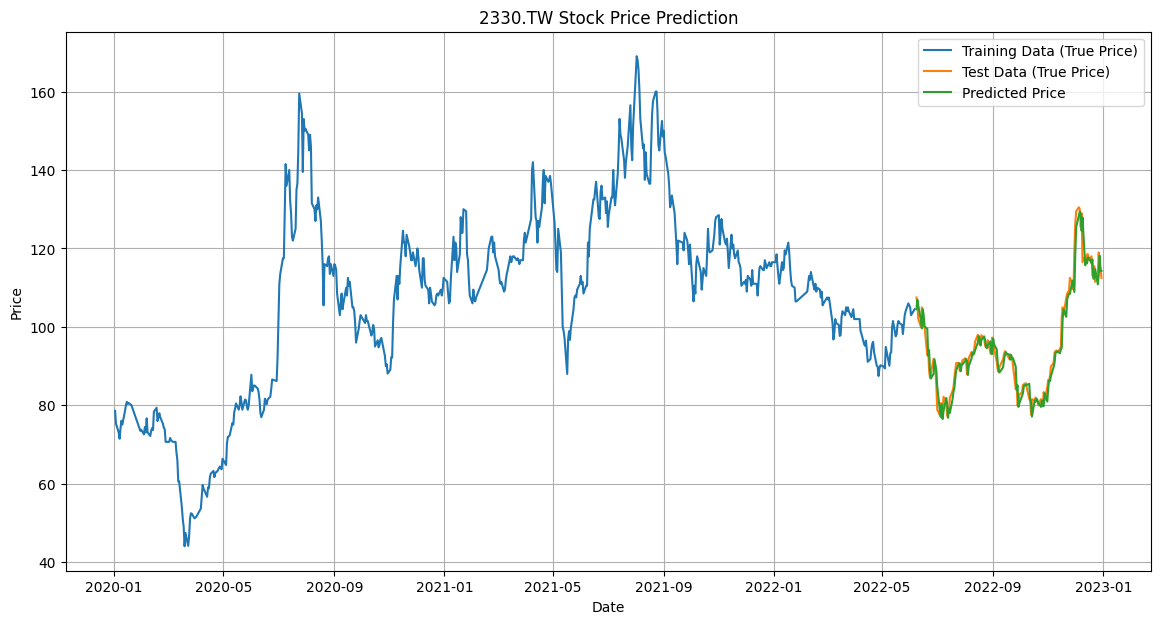

In [23]:
# 可視化訓練集與測試集
plt.figure(figsize=(14, 7))

# 繪製訓練集的真實價格
plt.plot(stock_data.index[:train_size], train_data, label="Training Data (True Price)")  # 訓練集真實值

# 調整測試資料的索引範圍，確保預測和實際值對齊
adjusted_index = stock_data.index[train_size + 1 : train_size + 1 + len(predictions_rescaled)]

# 繪製測試集的真實價格與預測價格
plt.plot(adjusted_index, y_test_rescaled[:len(predictions_rescaled)], label="Test Data (True Price)")  # 測試集真實值
plt.plot(adjusted_index, predictions_rescaled, label="Predicted Price")  # 預測值

# 繪圖標題與軸標籤
plt.title("2330.TW Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

# 加上圖例與格線
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

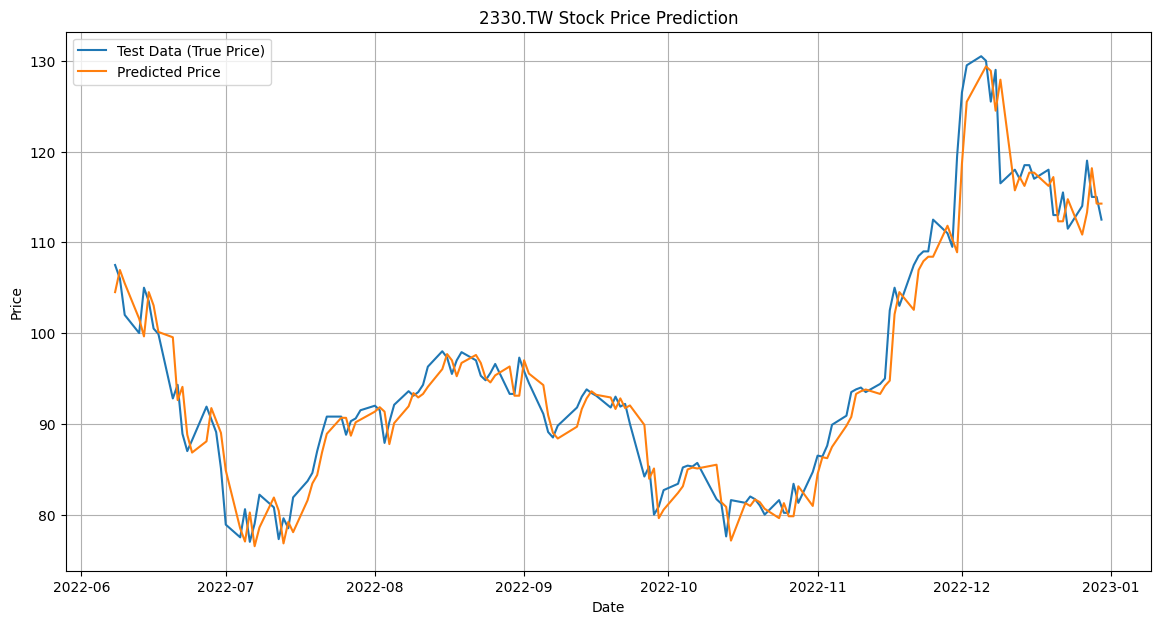

In [24]:
# 只可視化測試集
plt.figure(figsize=(14, 7))

# 調整測試資料的索引範圍，確保預測和實際值對齊
adjusted_index = stock_data.index[train_size + 1 : train_size + 1 + len(predictions_rescaled)]

# 繪製測試集的真實價格與預測價格
plt.plot(adjusted_index, y_test_rescaled[:len(predictions_rescaled)], label="Test Data (True Price)")  # 測試集真實值
plt.plot(adjusted_index, predictions_rescaled, label="Predicted Price")  # 預測值

# 繪圖標題與軸標籤
plt.title("2330.TW Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

# 加上圖例與格線
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

# 差分範例

In [25]:
example_df = pd.DataFrame({'Signal': [True, False, False, True, False]})
example_df

,Signal
0,True
1,False
2,False
3,True
4,False


In [26]:
# 布林轉換成整數
example_df = example_df.astype('int64')
example_df

,Signal
0,1
1,0
2,0
3,1
4,0


In [27]:
# 差分計算（後面減前面）
diff_example_df = example_df.diff()
diff_example_df

,Signal
0,NaN
1,-1.0
2,0.0
3,1.0
4,-1.0


In [28]:
# 將 NaN 填 0.0
diff_example_df.fillna(0.0)

,Signal
0,0.0
1,-1.0
2,0.0
3,1.0
4,-1.0
